In [1]:
using PyPlot
using DataFrames
using PyCall
@pyimport matplotlib.animation as anim  

In [2]:
function anima(x, y2,edos, nombre::ASCIIString)
    fig = figure(figsize=(5,5))
    cuadros = [[plot(x,y2, "b"), plot(x,edos[:,i], "k")] for i in 1:length(edos[1,:])]
    
    animacion = anim.ArtistAnimation(fig, cuadros, interval=200, blit=true) 
    animacion[:save](nombre*".mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end

function muestra_animacion(nombre::ASCIIString)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",base64(open(readbytes,nombre*".mp4")),"""" type="video/mp4"></video>"""))
end

muestra_animacion (generic function with 1 method)

In [3]:
G = readdlm("Greenland_input.txt", '\t')

45x4 Array{Float64,2}:
 0.0        -2230.77     -2230.77     71.6667
 0.0227273  -2292.63     -2292.63     70.3409
 0.0454545  -2250.39     -2250.39     69.0152
 0.0681818  -2061.61     -2061.61     67.6894
 0.0909091  -1406.43     -1406.43     66.3636
 0.113636    -626.842     -626.842    65.0379
 0.136364    -350.303     -350.303    63.7121
 0.159091    -259.054     -259.054    62.3864
 0.181818    -223.468     -223.468    61.0606
 0.204545    -156.348     -156.348    59.7348
 0.227273     -69.5695     -69.5695   58.4091
 0.25         654.747      962.503    57.0833
 0.272727     727.329     1697.24     55.7576
 ⋮                                           
 0.75        1415.01      2197.69     27.9167
 0.772727    1318.98      1822.74     26.5909
 0.795455     856.985      856.985    25.2652
 0.818182    -170.996     -170.996    23.9394
 0.840909    -267.75      -267.75     22.6136
 0.863636       5.62864      5.62864  21.2879
 0.886364     192.311      192.311    19.9621
 0.909091  

In [4]:
ρ_w = 1028
ρ_m =  3300
θ = 3000
B_0 = 1.928
C = 0.16612
K = 1.17
n = 3
p = 3
Q = 78800
R =  8.31
Tr = 280
g = 9.81

dx = 36000
ρ = 910
dt = 40
dtdx2 = 0.25*dt/(dx^2)
#acont = 2.43e-16

7.71604938271605e-9

In [5]:
x_scale = G[:,1]
surface_0 = G[:,3]
bedrock = G[:,2]
longitud = G[:,4]
h_old = surface_0 .- bedrock;

In [6]:
model = "greenland"
T_f = 0
T_kopp = 0       # 1 para activar, 0 para descativar
basal_sliding = 0  # 1 para activar, 0 para descativar
sea_level = 0

if model == "greenland"
    
    initial_conditions = readdlm("Greenland_input.txt", '\t')
    m_tune = 7.5
    dx = 36000
    dt = 40
    implicit = 1
    longitud = initial_conditions[:,4]
    
elseif model == "antartica"
    
    initial_conditions = readdlm("Antartic_input.txt", '\t')
    m_tune = 59
    dx = 120000
    dt = 200
    implicit = 2.5
    latitud = initial_conditions[:,4]
    
end

dtdx2 = dt/(2 * dx^2)

x_scale = initial_conditions[:,1]
surface_0 = initial_conditions[:,3]
bedrock = initial_conditions[:,2]
h_old = surface_0 .- bedrock;

T_ma = zeros(45)
T_ms = zeros(45)
a_abl = zeros(45)
a_acc = zeros(45)
mass_b = zeros(45)
slope = zeros(45)
diffusion = zeros(45)
α_prim = zeros(43)
β_prim = zeros(43)
γ_prim = zeros(43)
δ = zeros(43)
α = zeros(43)
β = zeros(43)
γ = zeros(43)
ω = zeros(45)
♊ = zeros(45)
b_slid = zeros(45)
h_new = zeros(45)
h_temporal = zeros(45)
surface = zeros(45, 100)
surface[:,1] = surface_0

### Ice-Temperature coupling
if T_f < 0
    
    T_star = T_f + 263.15
    
else
    
    T_star = T_f/2 + 263.15
    
end

if T_kopp == 0
    
    if model == "greenland"
    
        A = 2.43e-16
        
    elseif model == "antartica"
        
        A = 1.9e-15
    end
else
    
    A = m_tune * 0.139533635992 * exp(0.49836 / (280 - T_star)^1.17 - (9478 / T_star))
    
end


for t in 1:99
    
    ###Mass balance

    for i in 1:45

        if model == "greenland"
             
            if T_f > 0 
                T_fprim = 0
            else
                T_fprim = T_f
            end
            
            T_ma[i] = -5.31 - 0.007992*surface[i,t] + T_f
            T_ms[i] = 7.29 - 0.006277*surface[i,t] + T_f
            a_acc[i] = (-2.46257 + 0.1367*longitud[i] - 0.0016*longitud[i]^2)*1.0533^(T_fprim)
            
        elseif model =="antartica"
                
            T_ma[i] = -15.15 - 0.012*surface[i,t] + T_f
            T_ms[i] = 16.81 -0.00692*surface[i,t] - 0.27937 * latitud[i] + T_f
            a_acc[i] = 2.5*2^(T_ma[i]/10)

        end
        
        if T_ms[i] >= 0

            a_abl[i] = min(1.4*T_ms[i], 10)
            
        else
            
            a_abl[i] = 0

        end
        
        mass_b[i] = a_acc[i] - a_abl[i]

    end  
    
    ###Solution

    for i in 1:43
        
        slope[i+1] = (h_old[i+2] + bedrock[i+2]- h_old[i] - bedrock[i])/(2*dx)
        
        ###Basal_sliding
        
        if basal_sliding == 0
            
            b_slid = zeros(45)
            
        else
            
            b_const = A * 500000
            b_slid[i+1] = b_const * ρ^3 * g^3 * h_old[i+1]^4 * slope[i+1]^2 / (h_old[i+1] + 0.01 + 1028*(bedrock[i+1]-
            sea_level)/ρ)
            
        end
        
        diffusion[i+1] = -2 * A * h_old[i+1]^5 * ρ^3 * g^3 * slope[i+1]^2 /5 - b_slid[i+1]

        α_prim[i] = -dtdx2*(diffusion[i] + diffusion[i+1])
        β_prim[i] = -dtdx2*(diffusion[i+2] + 2*diffusion[i+1] + diffusion[i])
        γ_prim[i] = -dtdx2*(diffusion[i+1] + diffusion[i+2])

        α[i] = implicit * α_prim[i]
        β[i] = 1 + β_prim[i]*implicit
        γ_prim[i] = implicit * γ_prim[i]
        ω[i+1] = γ[i] / (β[i] - α[i] * ω[i])

        #δ[i] = h_old[i+1] + dt * mass_b[i+1] + α_prim[i] * bedrock[i] - β_prim[i] *bedrock[i+1] + γ_prim[i] * bedrock[i+2] +
        #(1-implicit)*(γ_prim[i] * h_old[i+2] - (β_prim[i] + 1)*h_old[i+1] + α_prim[i] * h_old[i])

        δ[i] = α_prim[i] * (implicit * (bedrock[i+1] - bedrock[i]) + (1 - implicit)*(surface[i+1,t] - surface[i,t]))
        - γ_prim[i] * (implicit * (bedrock[i+2] - bedrock[i+1]) + (1 - implicit)*(surface[i+2,t] - surface[i+1,t]))
        + h_old[i+1] + dt * mass_b[i+1]
        
        ♊[i+1] = (δ[i] + α[i] * h_old[i]) / (β[i] - α[i] * ω[i])

        h_temporal[45-i] = ω[45-i] * h_temporal[46 - i] + ♊[45-i]

        if h_temporal[i+1] < 0

            h_new[i+1] = 0

        else
            h_new[i+1] = h_temporal[i+1]

        end

    end

    surface[:,t+1] = h_new .+ bedrock
    
    h_old = h_new
    
end

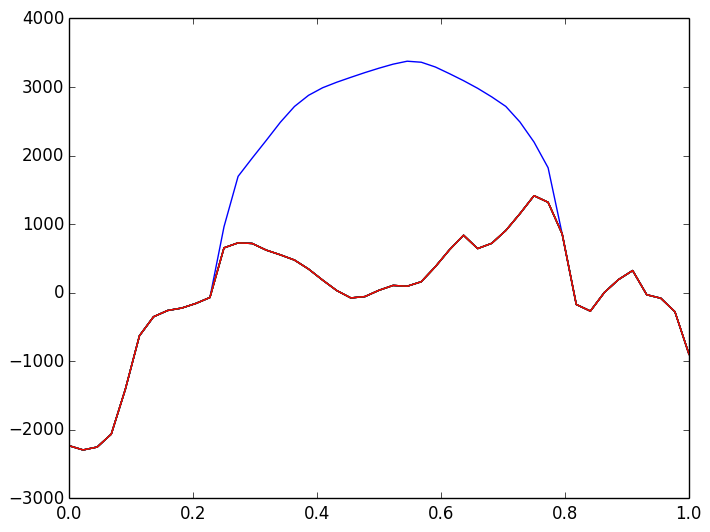

In [7]:
for i in 1:10:100
    plot(x_scale, surface[:,i])
    
end

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.3.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:32
 in anima at In[2]:3
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/claudiopierard/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /Users/claudiopierard/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading In[8], in expression starting on line 1

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAUUBtZGF0AAACrQYF//+p3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0NiByMjU1NSAwYzIxNDgwIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTYgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAACxxZYiEABT//vfHT8Cm6Plmy51FPSEwitj6SCi9WOzQMnUAAAMAAAMADGj5q+cbg4CsoYAABLeL/nB238uIA26o/g6K3f2MFfYuwT90HyqOkc31BynBQjvVRytUwqXS7PGIgUBvclF5Di7GNrUyuChdAk8U1wBfnJQVAxlRL/ASnUPBu6NUcceOoBAlwuRdLHFFKDKKr/XzGNqyeh9CSqe4bdMibt/lHXrimBlI9IJF3g6iEjVT/+5StOuvih4UIJ7RaY7dfEokOvw5/ZdXhkS1xScxmNtkQytrKDj70+h4k9jTUx30Ezc+FJ8a8z+Hfa7l5bRwIFNaE3wZ9PwGq8jaZyYONqXPvAuQGAqUED3lKH2hyT2WAATWQdysoD4jaSKN/a0yRjOG/p7G8PigAHmdjmQPrsfpcmmHLCcEOZIoDvai00WIlYd8LLXJ/5/qtHMs6PYtrY1T0wcVjYHJhQLYBdS8MwW5vW5XbdglmHu8i7praVepzTg8kPXCND1RYVGsS9fI4oIAOoBHXXP81hx5mYFSmCxSOIV9l+262TG+sFdoGIziizhwAgTYlhH8zKi6cGqxhyNAOpfp+Sm5HXL9jKyq3Eb3S4PNGifoYqjcn9oBoYlB/ppT73qFUdeaeUvMRMOTQuGB+dfb0ncKq22ep4jFCg23aQL/ROyrQU5zuFlKmBfYWq9kA+99BJrze73Dx7+6f5j0kg0kM6T05ziWBjUv5BPUJXkBjCGv7f/adqkdjlPP6rPoGmyovQh4TkLqibYaRzFbcArHroyv68Vkj3Yl/+JY3UfxHf/qv9C5W1LVfJQixbKlVrDZ7Fwv4ZtS0nhNbhDsm9ffB5/oyk7WHc4UrKkeIxTrYziCVdLfwlshnSY6zpX69nj//2YMVsX4H7zT3Uqnfz55BOI+zo+91kwBnva58OymSHh9N5FLRwL9rACXKK2320c8LbC3Tv0J5XbY6z0yitVo30eWMiDEBTYbf2mOByhr2cZQAIQ1FB+zwH9wXITDh4zf62J8/7zjsKKY3ElhPOLkC6DKH2H7OrdEocxvn//4PFkHCkDTItE0CihRNI/TFVhnokEX6/UV63FZ40pGoMAP0WAy4PimKCdiZ+XRd930TRDoDkbKdITI8HQpJtwyqhjLuhE7zVwQCInL9YB2fcoXiTlL8UK4FF51NANNEeakExNo6tksdwAhi3aCYoX03EavzaAWGkPJktKP4cI4aEzX9phc0SSt+Uu/S1/DPGpDkSaIFO7bOQqdyVrmbYLlkvcBuAqesVy3n4z4gCUhcPaJva3bovD/K1srvKMUqNIjzA1RlCyAqT74KUqJxaAECDRgRhCw4Rp0x7vru8S8hHW0sf8mw/y3PWk7krVJh1FTBqFjucOf4lbjduUwTrVdEL1STn/p/ZkwuKw4IKSAXNwxzvHGPPg6i7TubVFYF8lw5UWo2gaEgkZsHVEKLtt15qUDOoaQukrrfm8j6lSofkXLv+MuxgQw/4Fk/uW+6aA5HTRbhdsOqQA7y6hR5o5yggAfFz/tDjowmiaBh69LVxeC6FSAzqoXPa/snvsDbLncgNFNTqk60pqOrdrEMkYJfcxGDOH872wZl09CwOKkPyDL632zsy8RXUwHm72wHhJonUSbjqn6Y6tMpzxd+TZ4MPKoYUYCHQx0ZWLSYFSCow3rFiTYqCHeEOjLPw/cg7n1YyZWJw9YcHfM27cxl4xxk/DnIsu3z3PqyMxZb3mOvuIuLet7Px3d0FwlRyFTgTA4j/QK37ZyQ3BAhSSSXd5+8qDFBn/Y9tZdzUAZk0NsWiXVOvVSkwTCVggjvtAy4xlZn29ncnVRl0N+iBjUS60cr1cE4Mb28vUIEsGLjck+NyrJqUvY97l5kd4f43qRo1K6/FtTy6E8eurxbaZB0i/ELsANejgq6fPZ6jrKJt2rRrq/xsqx97/r+Q8f/0ObFarCfWbtgHfKjHeBbYF1sfG+LKri1RBrd+LsTKX/aQX5Eab7TIoVeNh+e4dP02i95b+tVT7p7fOVbLMWNJOYwfOA+QwJoVe1ADm8Rk2uzLe6qbwmzN/USLTLNEddmN+PFAMaWyTcWTz7gcnXVEIyj1pxUFk/Pqw1rqNkwX3RhDgF8Wwk0dD/SBJReiP0UlEGVeRJ5m3Kyd8kwRCD9jWwum3P1KRci/GYT5oYjsTPGUPZFQe1gSwVmKaFQvbTAkfB/5ejEP4uRh9pOIFvVBUpwJPFy8EGs+sGduAfKax3dBommaL2kxpkYXCnp9WLxBDyjpB7RqcHi+K//7iRJoit2f0VMftB0lc+yjedgzkcMyMwk6tt7LPhy38XjkIddDFJJxbrE3R/v1H1EN/mB4egX+AfxXmwokTCznkgGOakCg2KcMcGRgp3bLoitvLhhZTK0vc4k4uUNTIpvh/+7fYItmzeF8Evh3D/XoIx9mPby8kzivmE8Q981c94nU8UZ4Yoi3aPBLhYdmgpmpuiKVDYNPz0lu/+h1EQWXAn3aR2Vq8ANygXK5hxJryYgyW7PIQyWSIZywg4bkBMGIWmpUxw+KAhrZbZLEhim84QGUZxUnYSJy/1iO5jkLyj4rj+ug4+8376hGEUoh/5AFhFT0QvHyk0+ISETeKtM0u66sBSvOHYKeD6p+Q1eYxnt11iofEcmeROqiqtiXPsyitou89Gl4LUu4jhZzSl7HKTM7aa9stLOcIK1WbW31MzoTokcmOJCIdG5wIejytv0tZlPmMcgsyW4403Y9pvov3o9IZpQz1Q5aX9nV/ThtCi2Ez3N646ktkLWoPJNVOujBhvflc7+/q2JALa2uAkggBHviHPm8LVf8RcR4CtjAx3BI09M2QFkyPeWayP5UTmeCS3yFmRI9SiVpFYbxugFUTYkiWB8B1pV+emTOgnvs5r2QtOFVHRqwkceMfDzTY6G1CYtb1UgrhaiDHv2gu4sJ8u5fbxV7u2/J7+hGCjNPTELxjCY4LoRlX


 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at /Applications/Julia-0.4.3.app/Contents/Resources/julia/lib/julia/sys.dylib
 in vect at abstractarray.jl:32
 in anima at In[2]:3
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/claudiopierard/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /Users/claudiopierard/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading In[8], in expression starting on line 1


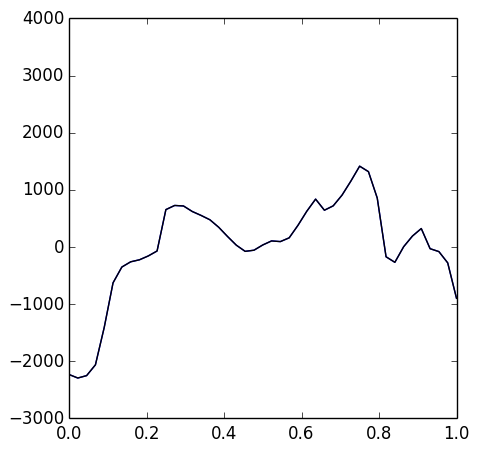

In [8]:
anima(x_scale, bedrock, surface, "Greenland_0K");
muestra_animacion("Greenland_0K")

**Shallow-ice approximation**

$$\sigma(b)~\tau_d = -\rho g H \nabla h$$

**La velocidad horizontal promedio es **

$$\vec u_d =  \frac{2}{n+2} A(T) H \tau_d ^n$$

**Parámetro de flujo**

$$A(T) = m \Big (\frac{1}{B_0} \Big) ^n exp \Bigg [\frac{3C}{(T_r - T)^K - \frac{Q}{RT}} \Bigg ] $$

**Velocidad en la base de la capa de hielo**

$$u(b) = A_b \frac{\tau_d^p}{Z^*}$$

$$ Z^* = H + min[(b-H_{sl}), 0]\frac{\rho_s}{\rho_i}$$

$$\frac{\partial H}{\partial t} = \dot a - \nabla(\vec u H)$$

con 

$$ \vec u = \vec u_d + u(b)$$

**Ajuste isoestático de la astenósfera:**

$$\frac{\partial b}{\partial t} = \frac{1}{\theta} \Big (b_0 - b - \frac{\rho_i}{\rho_m} H \Big )$$




## Método numérico

$$\frac{\partial H}{\partial t} = \dot a - \nabla(\vec u H)$$


$$H_{t+1} = H_t + \nabla [D_t(\omega \nabla(H + b)_{t+1} + (1-\omega) \nabla h_t)]\Delta t + \dot a \Delta t$$

$D_t$ es el parámetro de difusión, dado por:

$$D_t = \Bigg [ \frac{2}{5}A(T)H_t + \frac{A_b}{Z^*} \Bigg ] (\rho_i g)^n H_t^{n+1} |\nabla h_t|^{n-1}$$

La ecuación para $H_{t+1}$, se puede reescribir como un sistema tridiagonal de ecuaciones tal que:

$$\alpha_{i,t} H_{i-1,t+1} + \beta_{i,t} H_{i,t+1} + \gamma_{i,t} H_{i+1, t+1} = \delta_{i,t}$$

$$\frac{\partial H}{\partial t} = \dot a - \nabla(\vec u H)$$

$$\frac{\partial H}{\partial t} = \dot a - \nabla((\vec u_d + u(b)) H)$$

$$\frac{\partial H}{\partial t} = \dot a - \nabla(\vec u_d H + u(b)H)$$

$$\frac{\partial H}{\partial t} = \dot a - \frac{\partial}{\partial x}(\vec u_d H + u(b)H)$$

$$\frac{\partial H}{\partial t} = \dot a - \frac{\partial \vec u_d }{\partial x} H - \frac{\partial u(b)}{\partial x}H - \big(\vec u_d + u(b) \big ) \frac{\partial H}{\partial x}$$

Estrés:

$$\tau_d = -\rho_i g H \Delta h,$$

$\Delta h$ es la pendiente entre dos puntos en una rejlla.

La velocidad horizantal promedio es:

$$\vec u_d = \frac{2}{n+2}A(T)H\tau_g^n,$$

con $n =3$.

$$A(T) = m\frac{1}{B_0^n}exp \Bigg [ \frac{3C}{(T_r - T)^K} - \frac{Q}{RT} \Bigg ].$$



In [ ]:
function Greenland_FD(a)
    